## The goal and methods used

The goal of the model is to explain and predict UK internet retail sales over time. In particular, I want to:
 - See how much current online sales depend on past sales (recurring patterns and seasonality).
 - Measure how much Covid changed online shopping.
 - Compare different types of shops (e.g. food vs clothing/footwear) in terms of their online sales performance.

For this project I use "Retail Sales Index internet sales" dataset from https://www.ons.gov.uk. It contains internet sales in Great Britain by store type, month and year. The dataset is up to date and contains observations up to October 2025.
This is the *[Link to the dataset](https://www.ons.gov.uk/businessindustryandtrade/retailindustry/datasets/retailsalesindexinternetsales)*.


#### I use multiple linear regression (OLS) because:

 - It’s easy to explain and gives a clear answer to questions like: “If this factor goes up a bit, how much do we expect sales to change, assuming everything else stays the same?”
 - It shows what really matters the model can tell us which factors have a meaningful effect (for example, whether Covid or store type actually changed online sales).
 - It is a strong baseline model: if a simple linear model already explains most of the variation and performs well on test data, more complex models might not be necessary.
 - It supports scenario analysis – we can plug in different values of the predictors and get an estimated answer based on the data.

## Results

1. #### Sales are very similar from month to month
-----

The model shows that the strongest driver of internet sales this month is last month’s sales.
If last month was high, this month is usually high too. If last month was low, this month is usually low.
So internet sales don’t jump randomly – they move quite smoothly over time. This is useful for short-term planning and forecasting, because yesterday’s performance tells us a lot about tomorrow.

2. #### Covid gave a big boost to internet sales
-----
The Covid dummy in the model has a large positive effect.
It says that, during Covid months, internet sales were on average about 40+ units higher than they would have been without Covid, even after accounting for normal trends and past sales.
Covid clearly pushed people to buy more online, and this shows up very strongly in the data.

3. #### Some store types sell more online than others
-----
I use textile / clothing / footwear stores as the reference group.

All other store types (food, household goods, non-store retail, etc.) have negative coefficients, meaning:
 - Their internet sales are lower than textile/clothing/footwear.
 - Clothing and footwear are the strongest category for online sales, while other store types tend to sell less online.

4. #### Seasonal effects and long-term trend
-----
The model also includes sales from the same month one year ago. This effect is much smaller than the “last month” effect, but it still suggests some seasonal pattern (for example, similar behaviour every year).

5. #### How good and how safe is the model?
-----
On the test set:
* It explains about 93% of the variation in internet sales.
* Typical errors are around 20–25 units.
So the model is quite accurate for prediction.

The diagnostic plots show that:
* Errors are small for most months, but
* They can be larger when sales are very high, and
* There are a few extreme months (outliers).

This means the model is very good on average, but predictions in very unusual periods (for example, large spikes) should be treated with more caution.

6. #### Overall
-----
The model predicts internet sales well.
It tells us what matters:
 - last month’s sales,
 - the Covid period,
 - and store type.

It is useful for:
 - short-term forecasting,
 - understanding the Covid impact,
 - comparing store categories.


In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [38]:
df = pd.read_excel("data/internetreferencetables.xlsx",
                   sheet_name="IntValSA", header=3)


In [39]:
df.head()

,Time Period,All retailing excluding automotive fuel [Note 1],Predominantly food stores,Total of predominantly non-food stores [Note 2],Non-specialised stores [Note 2],"Textile, clothing and footwear stores [Note 2]",Household goods stores [Note 2],Other stores [Note 2],Non-store retailing
0,Agg/SIC,Agg 21X,Agg 1,Agg 12,47.19,Agg 5,Agg 7,Agg 13,Agg 14
1,Dataset identifier code,MZX6,MZX7,MZX8,MZX9,MZXV,MZY2,MZY3,MZY4
2,2008 Jan,219.5,36.9,91.6,16.4,23.9,21.6,29.7,91
3,2008 Feb,231.6,37.8,97.9,17.8,26,23.2,31,95.9
4,2008 Mar,238.3,37.7,99.5,18,26.6,24.3,30.5,101.2


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 9 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   Time Period                                       215 non-null    object
 1   All retailing excluding automotive fuel [Note 1]  215 non-null    object
 2   Predominantly food stores                         215 non-null    object
 3   Total of predominantly non-food stores [Note 2]   215 non-null    object
 4   Non-specialised stores [Note 2]                   215 non-null    object
 5   Textile, clothing and footwear stores [Note 2]    215 non-null    object
 6   Household goods stores [Note 2]                   215 non-null    object
 7   Other stores [Note 2]                             215 non-null    object
 8   Non-store retailing                               215 non-null    object
dtypes: object(9)
memory usage: 15.2+ 

In [41]:
df.shape

(215, 9)

### Data Cleaning

In [42]:
# Rename columns
df.columns = ["time_period", "all_retail_excl_autofuel", "food_stores", "non_food_stores_total", "non_specialised_stores", "textile_clothing_footwear_stores", "household_goods_stores", "other_stores", "non-store_retail"]

In [43]:
# Drop first 2 rows because they have NaN (Linear regression can’t use rows with NaN in the features)
df = df.iloc[2:].reset_index(drop=True)

In [44]:
df.head()

,time_period,all_retail_excl_autofuel,food_stores,non_food_stores_total,non_specialised_stores,textile_clothing_footwear_stores,household_goods_stores,other_stores,non-store_retail
0,2008 Jan,219.5,36.9,91.6,16.4,23.9,21.6,29.7,91
1,2008 Feb,231.6,37.8,97.9,17.8,26,23.2,31,95.9
2,2008 Mar,238.3,37.7,99.5,18,26.6,24.3,30.5,101.2
3,2008 Apr,247,38.8,104,18.6,27.2,25.4,32.9,104.2
4,2008 May,266.1,40.3,106.3,19.3,28.4,26.1,32.5,119.5


In [45]:
# Remove spaces after date
df['time_period'] = df['time_period'].str.strip()

# Data conversions
df['time_period'] = pd.to_datetime(df['time_period'], format="%Y %b")

cols = df.columns[1:]
df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

In [46]:
# Melt the df
id_cols = ["time_period"]  # keep the date
value_cols = cols

df_long = df.melt(
    id_vars=id_cols,
    value_vars=value_cols,
    var_name="store_type",
    value_name="internet_value"
)

### Reshaping and new columns

In [47]:
df_long.head(10)

,time_period,store_type,internet_value
0,2008-01-01,all_retail_excl_autofuel,219.5
1,2008-02-01,all_retail_excl_autofuel,231.6
2,2008-03-01,all_retail_excl_autofuel,238.3
3,2008-04-01,all_retail_excl_autofuel,247.0
4,2008-05-01,all_retail_excl_autofuel,266.1
5,2008-06-01,all_retail_excl_autofuel,270.5
6,2008-07-01,all_retail_excl_autofuel,281.4
7,2008-08-01,all_retail_excl_autofuel,289.0
8,2008-09-01,all_retail_excl_autofuel,294.5
9,2008-10-01,all_retail_excl_autofuel,280.9


In [48]:
df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time_period     1704 non-null   datetime64[ns]
 1   store_type      1704 non-null   object        
 2   internet_value  1704 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 40.1+ KB


In [49]:
# Add month count
df_long = df_long.sort_values(['store_type', 'time_period'])
df_long['time'] = df_long.groupby('store_type').cumcount() + 1 # Number months for each sector, how far along in time we are

# Add the actual value from the previous month for the same store type. If Jan was high, Feb is likely high too.
df_long['last_month_value'] = df_long.groupby('store_type')['internet_value'].shift(1)

# Add last year value (the same month). For “Food stores – Feb 2015” we look up “Food stores – Feb 2014”.
df_long['last_year_value'] = df_long.groupby('store_type')['internet_value'].shift(12)

# Add the difference
df_long['diff_1_month'] = df_long['internet_value'] - df_long['last_month_value']


In [50]:
# Create a dummy column (0,1) for Covid shock
df_long['covid'] = (
    (df_long['time_period'] >= "2020-04-01") &
    (df_long['time_period'] <= "2021-03-01")
).astype(int)

In [51]:
# Create store type dummies except 'all_retail_excl_autofuel', it's baseline
store_dum = pd.get_dummies(df_long['store_type'], prefix="is", drop_first=True)
df_long = pd.concat([df_long, store_dum], axis=1)

In [52]:
# Drop rows that can't have last_year_value and last_month_value (Linear regression can’t use rows with NaN in the features)
df_long = df_long.dropna(subset=['last_month_value', 'last_year_value'])

### Linear Regression

In [53]:
# Create X and y
feature_cols = ["time", "last_month_value", "last_year_value", "covid"] + \
               [c for c in df_long.columns if c.startswith("is_")]
#drop last dummy
feature_cols = feature_cols[:-1]

X = df_long[feature_cols]
y = df_long["internet_value"]

In [54]:
feature_cols = feature_cols[:-1]

In [55]:
# Fit linear regression
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # keep time order
)

model = LinearRegression().fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

#### OLS

In [56]:
X = sm.add_constant(X_train)
model = sm.OLS(y_train, X.astype(float))
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:         internet_value   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 4.844e+04
Date:                Fri, 07 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:35:38   Log-Likelihood:                -6175.7
No. Observations:                1286   AIC:                         1.237e+04
Df Residuals:                    1275   BIC:                         1.243e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

On the training sample (n = 1,286), the model explains 99.7% of the variation in internet sales (R² = 0.997, Adjusted R² = 0.997). The overall F-test is highly significant (p < 0.001), indicating that the predictors jointly provide strong explanatory power beyond a constant-only model.

The dummy is_textile_clothing_footwear_stores is chosen as the reference category, so all store-type coefficients are interpreted relative to textile, clothing and footwear stores. For example, the coefficient for is_food_stores (≈ −22.9) indicates that internet sales for food stores are on average around 22.9 units lower than for textile/clothing/footwear stores. Similarly, is_household_goods_stores (≈ −24.7) and is_non_store_retail (≈ −13.6) are also significantly below the reference category. This shows that textile/clothing/footwear stores are the strongest store type for internet sales in this period, while other store categories tend to have lower internet sales levels, all else equal.

1) Last month’s sales – coefficient ≈ 0.96
 - This number is very close to 1: if last month’s internet sales go up by 1 unit, this month’s sales go up by about 0.96 units, assuming everything else stays the same.
Sales this month are almost the same as last month, so there is strong short-term persistence and momentum.

2) Sales in the same month last year – coefficient ≈ 0.036
- This is a smaller effect, but still statistically important.
- If sales in the same month one year ago increase by 1 unit, this month’s sales increase by about 0.036 units, again holding other factors constant.
- This tells us there is some annual seasonality: what happened in, say, last year’s December still has a small influence on this December.

3) Covid dummy – coefficient ≈ +43.3
- The Covid variable takes the value 1 during Covid months and 0 otherwise.
- A coefficient of about +43.3 means that, after adjusting for time and past sales, months during the Covid period have internet sales that are on average around 43 units higher than comparable non-Covid months.
Covid gave a large, measurable boost to online retail sales, not just a small bump.')

#### Actual y values vs predicted y values

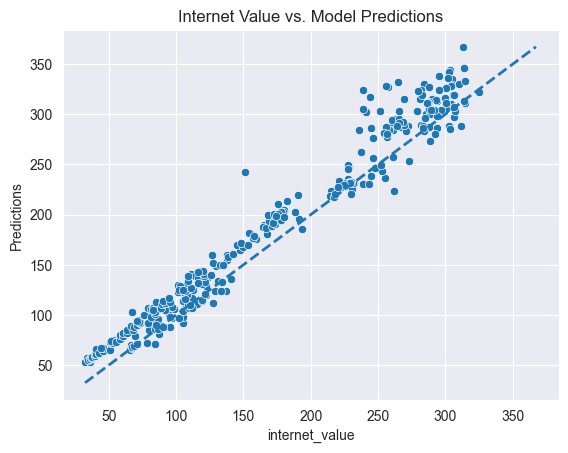

In [58]:
# Scatter plot of actual y values vs predicted values.
sns.scatterplot(x=y_test, y=y_pred_test)

plt.ylabel('Predictions')
plt.title('Internet Value vs. Model Predictions')
# 45° reference line (perfect predictions)
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())

plt.plot([min_val, max_val], [min_val, max_val], '--', linewidth=2)

plt.show()

The scatter plot of actual versus predicted internet sales on the test set shows that the points lie close to a straight 45° line, indicating that the model’s predictions track the true values very closely across the full range of sales.

The vertical deviations from the line (residuals) are generally small, with only a few larger errors, which is consistent with the low RMSE and high test R².

The two visible clusters (lower and higher sales regimes, corresponding to different time periods) are both well captured by the model, suggesting that it generalizes well across these different conditions.

#### Residuals

In [60]:
# Train Residuals
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test


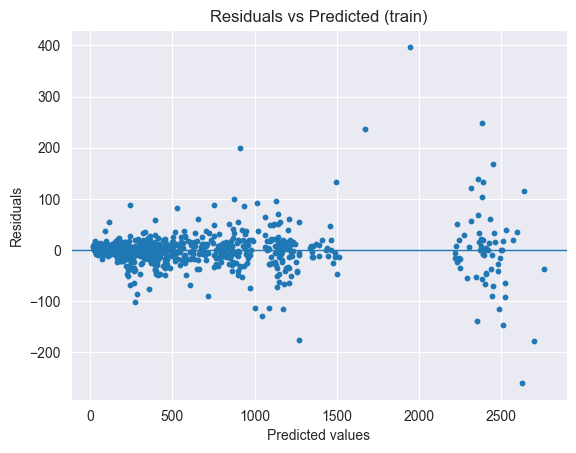

In [61]:
# Homoscedasticity (constant variance) – residuals vs fitted should look like random fuzz (no funnel).
plt.scatter(y_pred_train, residuals_train, s=10); plt.axhline(0, lw=1)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (train)"); plt.show()

The residuals are generally centred around zero across the full range of fitted values, indicating that the model is not systematically over- or under-predicting on the training data. However, the vertical spread of residuals is not constant: for lower and medium fitted values the residuals are relatively tight, while for higher fitted values (around 2,300–2,600) the residuals show much larger dispersion, including several extreme positive and negative outliers.

This pattern indicates heteroskedasticity, with larger errors occurring at higher levels of internet sales, and suggests that the classical constant-variance assumption is violated. As a result, the usual OLS standard errors and p-values may be somewhat optimistic, and robust (HC3) standard errors or a variance-stabilizing transformation (e.g. log of the target) would be more appropriate for inference.

Errors grow when sales are very high → be extra cautious when forecasting very large sales values; typical-range predictions are more accurate.

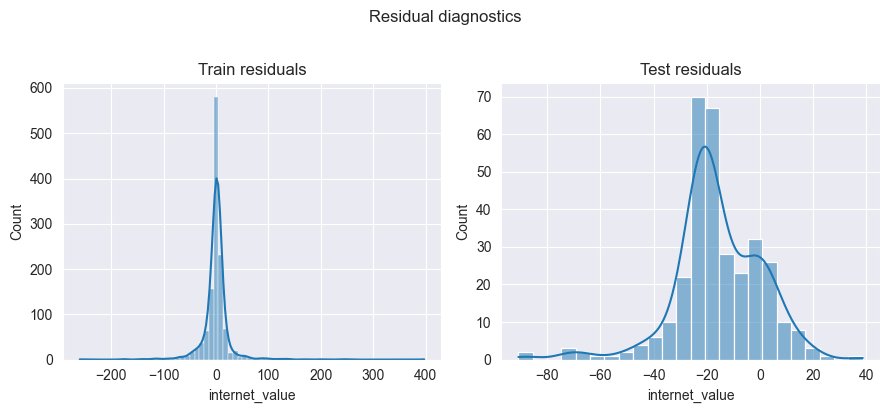

In [63]:
# Histplot (shows how errors are distributed)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
sns.histplot(residuals_train, ax=ax1, kde=True); ax1.set_title("Train residuals")
sns.histplot(residuals_test,  ax=ax2, kde=True); ax2.set_title("Test residuals")
fig.suptitle("Residual diagnostics", y=1.02)  # overall figure title
plt.tight_layout()

The mean training residual is essentially zero, -7.376162925658893e-14 as expected for OLS with an intercept. Residuals are tightly clustered around 0 and roughly symmetric, indicating that the model fits the bulk of the data well and is not systematically over- or under-predicting. However, there are a small number of large residuals in the tails, corresponding to a few extreme observations (outliers).

On the test set, residuals are approximately bell-shaped but clearly shifted to the left, with a mean of about -15.93
This indicates that, on average, the model tends to overpredict internet retail sales in the test period by around 16 units.
The left tail is somewhat heavier than the right, meaning that large overpredictions are more frequent than large underpredictions. This suggests a systematic bias in the test period, likely reflecting a change in behaviour of internet sales relative to the training period (e.g. structural shifts over time).

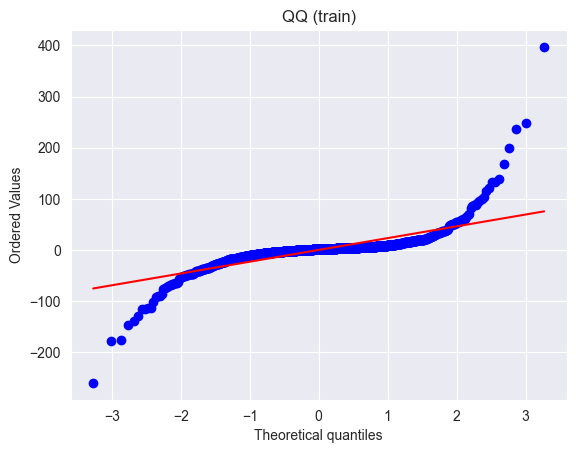

In [65]:
#QQ plot (QQ is stricter):
#Does my data look like it comes from a normal distribution?
stats.probplot(residuals_train, dist="norm", plot=plt); plt.title("QQ (train)"); plt.show()

The QQ plot of the model residuals shows a noticeable S-shaped pattern: points follow the 45° line in the central region but deviate systematically in the lower and upper tails. In addition, a small number of points in the tails lie far from the reference line, indicating potential outliers.The S-shaped QQ pattern suggests that the residuals have heavier tails than a normal distribution (i.e. extreme positive and negative residuals occur more often than under a Gaussian assumption). The isolated points far from the line indicate influential outliers.

Since classical OLS inference (t-tests, F-tests, confidence intervals) assumes normally distributed errors, the presence of heavy tails and outliers means that the reported p-values and confidence intervals may be somewhat optimistic (too narrow) and sensitive to these few extreme observations.

#### Metrics

In [67]:
# Compare predictions to the corresponding true targets

# (y_train vs y_pred_train) for training diagnostics
mean_absolute_error_train = metrics.mean_absolute_error(y_train, y_pred_train)
mean_squared_error_train = np.mean((y_train - y_pred_train)**2)
root_mean_squared_error_train = np.sqrt(np.mean((y_train - y_pred_train)**2))
r2_train = metrics.r2_score(y_train, y_pred_train)

# (y_test vs y_pred_test) for generalization performance
mean_absolute_error_test = metrics.mean_absolute_error(y_test, y_pred_test)
mean_squared_error_test = metrics.mean_squared_error(y_test, y_pred_test)
root_mean_squared_error_test = np.sqrt(np.mean((y_test - y_pred_test)**2))
r2_test = metrics.r2_score(y_test, y_pred_test)

print("Training set:")
print("  y_train                             =", y_train.shape, "(true targets for training rows)")
print("  y_pred_train                        =", y_pred_train.shape, "(predicted targets for training rows)")
print("  MAE_train (Mean Absolute Error)     =", mean_absolute_error_train)
print("  MSE_train (Mean Squared Error)      =", mean_squared_error_train)
print("  RMSE_train (Root Mean Squared Error)=", root_mean_squared_error_train)
print("  R2_train                            =", r2_train)

print("\nTest set:")
print("  y_test                              =", y_test.shape, "(true targets for test rows)")
print("  y_pred_test                         =", y_pred_test.shape, "(predicted targets for test rows)")
print("  MAE_test (Mean Absolute Error)      =", mean_absolute_error_test)
print("  MSE_test (Mean Squared Error)       =", mean_squared_error_test)
print("  RMSE_test (Root Mean Squared Error) =", root_mean_squared_error_test)
print("  R2_test                             =", r2_test)

Training set:
  y_train                             = (1286,) (true targets for training rows)
  y_pred_train                        = (1286,) (predicted targets for training rows)
  MAE_train (Mean Absolute Error)     = 13.419140610237056
  MSE_train (Mean Squared Error)      = 868.4125698473783
  RMSE_train (Root Mean Squared Error)= 29.46884066004936
  R2_train                            = 0.9973750144675779

Test set:
  y_test                              = (322,) (true targets for test rows)
  y_pred_test                         = (322,) (predicted targets for test rows)
  MAE_test (Mean Absolute Error)      = 18.435653310273864
  MSE_test (Mean Squared Error)       = 530.7498382288657
  RMSE_test (Root Mean Squared Error) = 23.03800855605505
  R2_test                             = 0.9322550494905476


---TRAINING SET---

MAE_train ≈ 13.41
→ On average, the model is off by about 13.4 units on the training data.

MSE_train ≈ 868.41
→ Average squared error. Mostly useful as an intermediate step; not very interpretable directly.

RMSE_train ≈ 29.47
→ Typical error on train, in the same units as the target.
The fact that RMSE > MAE is normal; squaring emphasises big errors.

R2_train ≈ 0.9978
→ The model explains about 99.8% of the variance in training data.
Extremely high, consistent with the OLS summary.

Note: RMSE on train is relatively large compared to MAE → that tells you the train set has some pretty big outliers (a few very large residuals) that blow up the squared error. That matches your “train residuals” hist plot: tall peak + very long tails.

On the training set (n = 1,286), the model achieves MAE = 13.4, RMSE = 29.5, and R² = 0.998, meaning it explains almost all of the variation in internet sales.
On the held-out test set (n = 322), performance remains strong, with MAE = 18.5, RMSE = 23.0, and R² = 0.933. The slightly higher MAE on test indicates modestly larger average errors on unseen data, while the lower RMSE compared to training suggests that the most extreme outliers occur mainly in the training period. Overall, the model generalizes well and retains high explanatory power on unseen data.

--- TRAINING VS TEST---

MAE_test > MAE_train (18.5 vs 13.4) → errors on test are slightly larger on average.

RMSE_test < RMSE_train (23.0 vs 29.5) → the really huge errors are actually more common on train than on test.

Typical errors are a bit bigger on test (higher MAE), but the very extreme errors are worse on train (higher RMSE).
That’s consistent with earlier plots: training data has some extreme outlier periods; test data is a bit “calmer”.

In [71]:
print('---RMSE GAP---')
# how much worse (or better) the test RMSE is compared to the train RMSE
rmse_train = root_mean_squared_error_train
rmse_test  = root_mean_squared_error_test

rmse_gap = (rmse_test - rmse_train) / rmse_train
rmse_gap_percent = rmse_gap * 100

print("RMSE gap (fraction):", rmse_gap)
print("RMSE gap (%):", rmse_gap_percent)
print('Test RMSE is about',round(rmse_gap_percent,1),'% lower than train RMSE → no overfitting; training period just has more extreme values.')

---RMSE GAP---
RMSE gap (fraction): -0.21822480830447225
RMSE gap (%): -21.822480830447226
Test RMSE is about -21.8 % lower than train RMSE → no overfitting; training period just has more extreme values.


---CONCLUSION---

On the training set (n = 1,286), the model achieves MAE = 13.4, RMSE = 29.5, and R² = 0.998, meaning it explains almost all of the variation in internet sales.
On the held-out test set (n = 322), performance remains strong, with MAE = 18.5, RMSE = 23.0, and R² = 0.933.
The slightly higher MAE on test indicates modestly larger average errors on unseen data, while the lower RMSE compared to training suggests that the most extreme outliers occur mainly in the training period.
Overall, the model generalizes well and retains high explanatory power on unseen data.